## Import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model, load_model

from tensorflow.keras.layers import Input, Masking, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.layers import LSTM, GRU, Bidirectional, TimeDistributed, Lambda, Bidirectional

from keras import backend as K

from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



## 사용 X

In [ ]:
def create_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            data = pd.read_csv(base_path + csv_path)

            features = data.loc[:, data.columns != 'class']

            X.append(features.to_numpy())
            y.append(data["class"].iloc[0])

    X = np.stack(X, axis=0)
    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
# 데이터 좌우 대칭 -> x 값만 변화, y값 변화 없음
def revert_datasets(df):
    revert_data = df.copy()

    for feature in df.columns:
        if feature[-2:] == '_x':
            revert_data[feature] = 1 - df[feature]
    return revert_data

## 6 Classes Dataset

In [ ]:
# 'backhand': 0, 'forehand': 1, 'volley': 2, 'service/smash': 3

sequence_length = 60

def create_dataset_6cls():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # volley를 하나로 묶음
            if folder == 'backhand':
                # 'backhand_volley'
                if int(csv_path[9:-4]) >= 191 and int(csv_path[9:-4]) <= 247:
                    df.loc[df['class'] == 0, 'class'] = 2

            if folder == 'forehand':
                # 'forehand_volley'
                if int(csv_path[9:-4]) >= 414 and int(csv_path[9:-4]) <= 470:
                    df.loc[df['class'] == 1, 'class'] = 2

            # service와 smash를 하나로 묶음
            if folder == 'service' or folder == 'smash':
                # service
                if int(csv_path[9:-4]) >= 471 and int(csv_path[9:-4]) <= 650:
                    df.loc[df['class'] == 1, 'class'] = 3

                # smash
                if int(csv_path[9:-4]) >= 651 and int(csv_path[9:-4]) <= 704:
                    df.loc[df['class'] == 1, 'class'] = 3


            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])

    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

IndentationError: expected an indented block after 'if' statement on line 28 (2453213477.py, line 32)

In [ ]:
X, y = create_dataset_6cls()

In [ ]:
print(X.shape)
print(y.shape)

(10419, 60, 26)
(10419,)


In [ ]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123, stratify=y)

# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 6
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(7293, 60, 26)
(7293, 6)
(3126, 60, 26)
(3126, 6)


## 4 Classes dataset

In [ ]:
sequence_length = 17

def create_revert_dataset():
    X=[]
    y=[]

    folders = ['backhand', 'forehand', 'service', 'smash']
    for folder in folders:
        base_path = f'../keypoints/{folder}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            # 60개씩 끊어서 저장
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                # 데이터 변환
                # revert_data = revert_datasets(df)

                # X.append(revert_data.values[1:])
                # y.append(revert_data['class'].values[0])

                features = data.loc[:, data.columns != 'class']
                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])



    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
X, y = create_revert_dataset()

In [ ]:
print(X.shape)
print(y.shape)

(682, 50, 26)
(682,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True)

In [ ]:
# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

IndexError: index 4 is out of bounds for axis 1 with size 4

## New  - train, valid, test를 직접 분리해서 만든 dataset

In [ ]:
# 각 csv 파일 번호에 matching되는 motion
# 0 - 71: backhand2hands -> backhand
# 72 - 124: backhand
# 125 - 190: backhand_slice -> backhand
# 191 - 247: backhand_volley -> volley
# 248 - 306: forehand_flat -> forehand
# 307 - 355: forehand_openstands -> forehand
# 356 - 413: forehand_slice -> forehand
# 414 - 470: forehand_volley -> volley
# 471 - 539: flat_service -> service/smash
# 540 - 600: kick_service -> service/smash
# 601 - 650: slice_service -> service/smash
# 651 - 704: smash -> service/smash

In [ ]:
# backhand: 191개
# forehand: 166개
# volley: 114개
# service/smash: 234개
# 총 705개

In [ ]:
# train:valid:test
# 7 : 2 : 1
# backhand: 134 : 38 : 19
# forehand: 117 : 34 : 17
# volley: 80 : 23 : 11
# service/smash: 164 : 47 : 23

# 0 - 71: 50, 15, 7 (72개) -> backhand
# 72 - 124: 37, 11, 5 (53개) -> backhand
# 125 - 190: 46, 14, 6 (66개) -> backhand
# 191 - 247: 40, 11, 6 (57개)-> volley
# 248 - 306: 41, 12, 6 (59개) -> forehand
# 307 - 355: 34, 10, 5 (49개) -> forehand
# 356 - 413: 40, 12, 6 (58개) -> forehand
# 414 - 470: 40, 11, 6 (57개) -> volley
# 471 - 539: 48, 14, 7 (69개) -> service/smash
# 540 - 600: 43, 12, 6 (61개) -> service/smash
# 601 - 650: 35, 10, 5 (50개)-> service/smash
# 651 - 704: 38, 11, 5 (54개) -> service/smash

In [ ]:
sequence_length = 60

def create_datasets():
    X_train = []
    y_train = []
    X_valid = []
    y_valid = []
    X_test = []
    y_test = []

    folders = ['train', 'valid', 'test']
    motions = ['backhand', 'forehand', 'servicesmash', 'volley']
    for folder in folders:
        for motion in motions:
            base_path = f'../keypoints/{folder}/{folder}_{motion}/'
            for csv_path in os.listdir(base_path):
                df = pd.read_csv(base_path + csv_path)
                df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

                if motion == 'servicesmash':
                    df['class'] = 2

                if motion == 'volley':
                    df['class'] = 3

                # Sequence Dataset으로 변경
                num_rows = df.shape[0]
                num_batches = num_rows - sequence_length + 1

                for i in range(num_batches):
                    data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                    features = data.loc[:, data.columns != 'class']

                    if folder == 'train':
                        X_train.append(features.to_numpy())
                        y_train.append(data["class"].iloc[0])

                    elif folder == 'valid':
                        X_valid.append(features.to_numpy())
                        y_valid.append(data["class"].iloc[0])

                    elif folder == 'test':
                        X_test.append(features.to_numpy())
                        y_test.append(data["class"].iloc[0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = create_datasets()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7415, 60, 26)
(7415,)
(2249, 60, 26)
(2249,)
(755, 60, 26)
(755,)


In [ ]:
# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)
y_test = le.fit_transform(y_test)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7415, 60, 26)
(7415, 4)
(2249, 60, 26)
(2249, 4)
(755, 60, 26)
(755, 4)


## New - train, valid, test를 나중에 분리하는 코드

In [ ]:
# 연속된 frame 2개를 평균내어 만든 데이터셋
input_folder = '/content/drive/MyDrive/keypoints/datasets/volley/'
output_folder = '/content/drive/MyDrive/keypoints/new_datasets/volley/'

file_list = os.listdir(input_folder)

for file_name in file_list:
    if file_name.endswith('.csv'):
        input_file_path = os.path.join(input_folder, file_name)

        df = pd.read_csv(input_file_path)

        for i in range(0, len(df) -1, 2):
            avg_row = (df.iloc[i, :] + df.iloc[i + 1, :]) / 2
            if i == 0:
                new_df = avg_row.to_frame().T
            else:
                new_df = pd.concat([new_df, avg_row.to_frame().T], ignore_index=True)

        # df가 홀수일때는 평균X
        if len(df) % 2 == 1:
                new_df = pd.concat([new_df, df.iloc[-1, :].to_frame().T], ignore_index=True)

        output_file_path = os.path.join(output_folder, f"{file_name}")
        new_df.to_csv(output_file_path, index=False)

In [ ]:
sequence_length = 30

def create_datasets():
    X = []
    y = []

    motions = ['backhand', 'forehand', 'servicesmash', 'volley']
    for motion in motions:
        base_path = f'/content/gdrive/MyDrive/keypoints/new_datasets/{motion}/'
        for csv_path in os.listdir(base_path):
            df = pd.read_csv(base_path + csv_path)
            df = df.drop(df.columns[2:10], axis=1) # ear와 eye에 관련된 column 제거

            if motion == 'backhand':
                df['class'] = 0

            elif motion == 'forehand':
                df['class'] = 1

            elif motion == 'servicesmash':
                df['class'] = 2

            elif motion == 'volley':
                df['class'] = 3

            # Sequence Dataset으로 변경
            num_rows = df.shape[0]
            num_batches = num_rows - sequence_length + 1

            for i in range(num_batches):
                data = df.iloc[i : i+sequence_length, :].reset_index(drop=True)

                features = data.loc[:, data.columns != 'class']

                X.append(features.to_numpy())
                y.append(data["class"].iloc[0])

    X = np.stack(X, axis=0)

    X = np.array(X)
    y = np.array(y)

    return X, y


In [ ]:
X, y = create_datasets()
print(X.shape)
print(y.shape)

(5638, 30, 26)
(5638,)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123, stratify=y)

# One-hot Encoding
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

num_classes = 4
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(3946, 30, 26)
(3946, 4)
(1692, 30, 26)
(1692, 4)


## GRU

In [ ]:
# Model 정의
model = Sequential([
    Input(shape=(sequence_length, 26)),
    Masking(mask_value=0.0),
    GRU(42, dropout=0.1),
    BatchNormalization(),
    Dropout(0.5),
    Dense(42, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Model 정의
model = Sequential([
    GRU(64, dropout=0.1, input_shape=(sequence_length, 26)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                17664     
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 22340 (87.27 KB)
Trainable params: 22212 (86.77 KB)
Non-trainable params: 128 (512.00 Byte)
______________

In [ ]:
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/keypoints/models/model/model11.h5', verbose=0, save_best_only=True, period=1)
# period: 1번의 epoch일 때마다 valid loss가 가장 낮은 모델을 저장 -> checkpoint 역할
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 32
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=batch_size,
    callbacks=[checkpoint]
)

Epoch 1/200
124/124 [==============================] - 5s 15ms/step - loss: 1.2522 - acc: 0.4607 - val_loss: 1.2765 - val_acc: 0.3794
Epoch 2/200
124/124 [==============================] - 1s 8ms/step - loss: 0.9049 - acc: 0.6158 - val_loss: 1.4196 - val_acc: 0.2453
Epoch 3/200
124/124 [==============================] - 1s 9ms/step - loss: 0.7999 - acc: 0.6685 - val_loss: 2.0964 - val_acc: 0.2512
Epoch 4/200
124/124 [==============================] - 2s 16ms/step - loss: 0.7497 - acc: 0.6977 - val_loss: 0.8759 - val_acc: 0.6253
Epoch 5/200
124/124 [==============================] - 1s 9ms/step - loss: 0.7158 - acc: 0.7111 - val_loss: 1.9278 - val_acc: 0.3978
Epoch 6/200
124/124 [==============================] - 1s 7ms/step - loss: 0.6805 - acc: 0.7278 - val_loss: 1.7637 - val_acc: 0.3918
Epoch 7/200
124/124 [==============================] - 1s 9ms/step - loss: 0.6373 - acc: 0.7504 - val_loss: 0.9294 - val_acc: 0.6684
Epoch 8/200
124/124 [==============================] - 1s 11ms/step

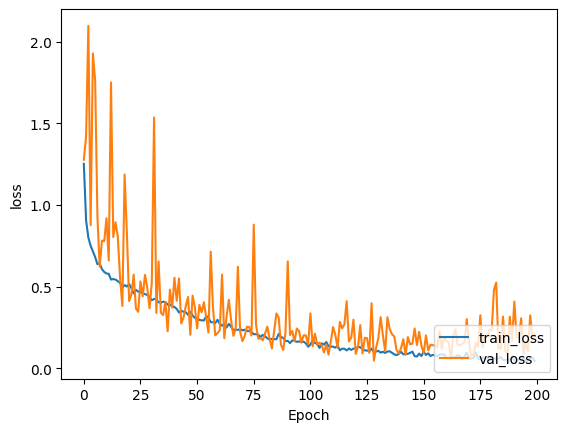

In [ ]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

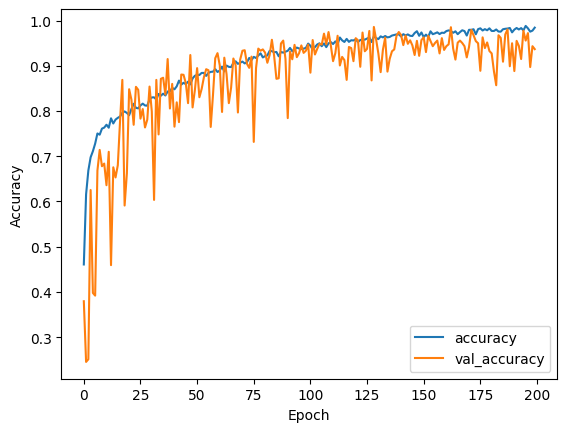

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('/content/gdrive/MyDrive/keypoints/models/model/model11.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

53/53 [==============================] - 0s 5ms/step - loss: 0.2104 - acc: 0.9368
Accuracy on validation dataset = 0.936761200428009
53/53 [==============================] - 0s 4ms/step - loss: 0.0462 - acc: 0.9858
Accuracy on validation dataset = 0.9858155846595764


In [ ]:
# 모델 저장
model.save('/content/gdrive/MyDrive/keypoints/models/gru/gru64masking.h5')

## LSTM

In [ ]:
units = 64
model = Sequential([
    Dropout(0.1, input_shape=(sequence_length, 26)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5), merge_mode='concat'),
    TimeDistributed(Dropout(0.1)),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(num_classes, activation='softmax')),
    Lambda(function=lambda x: K.mean(x, axis=1))
])

In [ ]:
model = Sequential([
    Input(shape=(sequence_length, 26)),
    Masking(mask_value=0.0),
    LSTM(45, dropout=0.1, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    #LSTM(64, dropout=0.1),
    #BatchNormalization(),
    #Dropout(0.3),
    Dense(45, activation='relu'), # , kernel_regularizer=l2(0.001)
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 30, 26)            0         
                                                                 
 lstm_5 (LSTM)               (None, 45)                12960     
                                                                 
 batch_normalization_9 (Bat  (None, 45)                180       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 45)                0         
                                                                 
 dense_20 (Dense)            (None, 45)                2070      
                                                                 
 dense_21 (Dense)            (None, 4)                 184       
                                                     

In [ ]:
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/keypoints/models/model/model12.h5', verbose=1, save_best_only=True, period=1)
# scheduler = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, verbose=1, mode='auto')

batch_size = 16

history = model.fit(
    X_train,
    y_train,
    epochs=300,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint]
)

Epoch 1/300
243/247 [============================>.] - ETA: 0s - loss: 1.0480 - accuracy: 0.5453
Epoch 1: val_loss improved from inf to 1.14334, saving model to /content/gdrive/MyDrive/keypoints/models/model/model12.h5
247/247 [==============================] - 13s 21ms/step - loss: 1.0467 - accuracy: 0.5466 - val_loss: 1.1433 - val_accuracy: 0.5591
Epoch 2/300
241/247 [============================>.] - ETA: 0s - loss: 0.8116 - accuracy: 0.6670
Epoch 2: val_loss improved from 1.14334 to 0.98531, saving model to /content/gdrive/MyDrive/keypoints/models/model/model12.h5
247/247 [==============================] - 3s 11ms/step - loss: 0.8116 - accuracy: 0.6675 - val_loss: 0.9853 - val_accuracy: 0.6206
Epoch 3/300
247/247 [==============================] - ETA: 0s - loss: 0.7267 - accuracy: 0.7005
Epoch 3: val_loss did not improve from 0.98531
247/247 [==============================] - 2s 10ms/step - loss: 0.7267 - accuracy: 0.7005 - val_loss: 1.1980 - val_accuracy: 0.5638
Epoch 4/300
246/2

In [ ]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

model.load_weights('/content/gdrive/MyDrive/keypoints/models/model/model12.h5')

loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Accuracy on validation dataset = {accuracy}")

53/53 [==============================] - 0s 4ms/step - loss: 0.5636 - accuracy: 0.8694
Accuracy on validation dataset = 0.8693853616714478
53/53 [==============================] - 0s 5ms/step - loss: 0.0370 - accuracy: 0.9923
Accuracy on validation dataset = 0.9923167824745178


In [ ]:
model.save('/content/gdrive/MyDrive/keypoints/models/model_2lstm_seq80.h5')

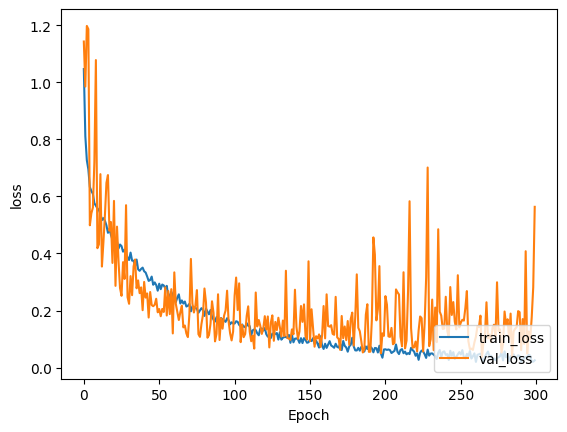

In [ ]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

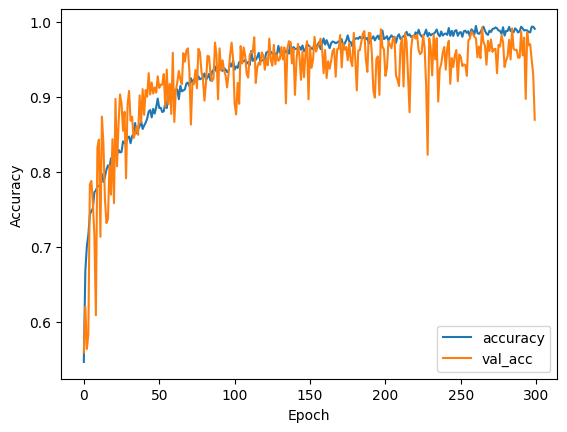

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
model.save('/content/gdrive/MyDrive/keypoints/models/lstm/1lstm64.h5')